In [7]:
!rm -rf pytorch_utils
!git clone https://github.com/rahuldsce/pytorch_utils.git

Cloning into 'pytorch_utils'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 46 (delta 15), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (46/46), 18.04 KiB | 18.04 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
from pytorch_utils import dataset, model
train, test = dataset.cifar10()

Files already downloaded and verified
Files already downloaded and verified


In [11]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
cifar10_model = model.Cifar10_BN().to(device)
summary(cifar10_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 16, 16, 16]             512
           Conv2d-11           [-1, 16, 16, 16]           2,304
             ReLU-12           [-1, 16, 16, 16]               0
      BatchNorm2d-13           [-1, 16, 16, 16]              32
          Dropout-14           [-1, 16,

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [15]:
import torch.optim as optim
import torch.nn as nn

optimizer = optim.SGD(cifar10_model.parameters(), lr=0.1, momentum=0.9)
EPOCHS = 20

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(cifar10_model, device, train_loader, optimizer, epoch)
    test(cifar10_model, device, test_loader)

EPOCH: 0


Loss=1.3035500049591064 Batch_id=390 Accuracy=41.86: 100%|██████████| 391/391 [00:24<00:00, 15.95it/s]



Test set: Average loss: 1.4134, Accuracy: 4915/10000 (49.15%)

EPOCH: 1


Loss=1.2327959537506104 Batch_id=390 Accuracy=54.40: 100%|██████████| 391/391 [00:31<00:00, 12.38it/s]



Test set: Average loss: 1.3321, Accuracy: 5510/10000 (55.10%)

EPOCH: 2


Loss=0.9674174189567566 Batch_id=390 Accuracy=59.33: 100%|██████████| 391/391 [00:25<00:00, 15.51it/s]



Test set: Average loss: 1.1885, Accuracy: 5717/10000 (57.17%)

EPOCH: 3


Loss=0.8375774621963501 Batch_id=390 Accuracy=61.91: 100%|██████████| 391/391 [00:25<00:00, 15.24it/s]



Test set: Average loss: 1.1100, Accuracy: 6111/10000 (61.11%)

EPOCH: 4


Loss=1.0798912048339844 Batch_id=390 Accuracy=64.15: 100%|██████████| 391/391 [00:24<00:00, 15.91it/s]



Test set: Average loss: 0.9540, Accuracy: 6574/10000 (65.74%)

EPOCH: 5


Loss=0.9921860694885254 Batch_id=390 Accuracy=66.12: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s]



Test set: Average loss: 0.9922, Accuracy: 6605/10000 (66.05%)

EPOCH: 6


Loss=0.8147837519645691 Batch_id=390 Accuracy=67.66: 100%|██████████| 391/391 [00:24<00:00, 15.87it/s]



Test set: Average loss: 0.9115, Accuracy: 6754/10000 (67.54%)

EPOCH: 7


Loss=0.9323393106460571 Batch_id=390 Accuracy=68.65: 100%|██████████| 391/391 [00:24<00:00, 16.10it/s]



Test set: Average loss: 0.8953, Accuracy: 6929/10000 (69.29%)

EPOCH: 8


Loss=0.702168345451355 Batch_id=390 Accuracy=70.27: 100%|██████████| 391/391 [00:24<00:00, 15.91it/s]



Test set: Average loss: 0.9176, Accuracy: 6807/10000 (68.07%)

EPOCH: 9


Loss=0.8132444620132446 Batch_id=390 Accuracy=70.81: 100%|██████████| 391/391 [00:24<00:00, 15.84it/s]



Test set: Average loss: 0.8283, Accuracy: 7104/10000 (71.04%)

EPOCH: 10


Loss=0.6217821836471558 Batch_id=390 Accuracy=72.09: 100%|██████████| 391/391 [00:24<00:00, 15.82it/s]



Test set: Average loss: 0.8494, Accuracy: 7042/10000 (70.42%)

EPOCH: 11


Loss=0.7095757722854614 Batch_id=390 Accuracy=72.34: 100%|██████████| 391/391 [00:24<00:00, 15.79it/s]



Test set: Average loss: 0.7677, Accuracy: 7279/10000 (72.79%)

EPOCH: 12


Loss=0.7923510670661926 Batch_id=390 Accuracy=73.05: 100%|██████████| 391/391 [00:24<00:00, 15.72it/s]



Test set: Average loss: 0.7623, Accuracy: 7323/10000 (73.23%)

EPOCH: 13


Loss=0.7168078422546387 Batch_id=390 Accuracy=73.37: 100%|██████████| 391/391 [00:24<00:00, 15.85it/s]



Test set: Average loss: 0.7438, Accuracy: 7415/10000 (74.15%)

EPOCH: 14


Loss=0.7681896090507507 Batch_id=390 Accuracy=74.00: 100%|██████████| 391/391 [00:24<00:00, 15.89it/s]



Test set: Average loss: 0.7176, Accuracy: 7557/10000 (75.57%)

EPOCH: 15


Loss=0.7503488063812256 Batch_id=390 Accuracy=74.73: 100%|██████████| 391/391 [00:24<00:00, 16.05it/s]



Test set: Average loss: 0.7096, Accuracy: 7539/10000 (75.39%)

EPOCH: 16


Loss=0.6047715544700623 Batch_id=390 Accuracy=74.88: 100%|██████████| 391/391 [00:24<00:00, 15.92it/s]



Test set: Average loss: 0.7069, Accuracy: 7539/10000 (75.39%)

EPOCH: 17


Loss=0.7196081876754761 Batch_id=390 Accuracy=74.93: 100%|██████████| 391/391 [00:24<00:00, 15.81it/s]



Test set: Average loss: 0.6630, Accuracy: 7694/10000 (76.94%)

EPOCH: 18


Loss=0.652751088142395 Batch_id=390 Accuracy=75.53: 100%|██████████| 391/391 [00:24<00:00, 15.99it/s]



Test set: Average loss: 0.7172, Accuracy: 7489/10000 (74.89%)

EPOCH: 19


Loss=1.0018490552902222 Batch_id=390 Accuracy=75.65: 100%|██████████| 391/391 [00:24<00:00, 15.93it/s]



Test set: Average loss: 0.6759, Accuracy: 7703/10000 (77.03%)



In [17]:
torch.save(cifar10_model.state_dict(), f"./cifar_10_bn.pth")

In [18]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def show_misclassified_images_from_model(model, model_path, data_loader, class_labels, image_count):
  model.load_state_dict(torch.load(model_path))
  model.to(device)
  model.eval()

  correct = 0
  figure = plt.figure(figsize=(15,15))
  count = 0
  with torch.no_grad():
      for data, target in data_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

          for idx in range(len(pred)):
            i_pred, i_act = pred[idx], target[idx]
            if i_pred != i_act:
                annotation = "Actual: %s, Predicted: %s" % (class_labels[i_act], class_labels[i_pred])
                count += 1
                plt.subplot(5, 2, count)
                plt.axis('off')
                imshow(data[idx].cpu())
                plt.annotate(annotation, xy=(0,0), xytext=(0,-1.2), fontsize=13)
            if count == image_count:
                return

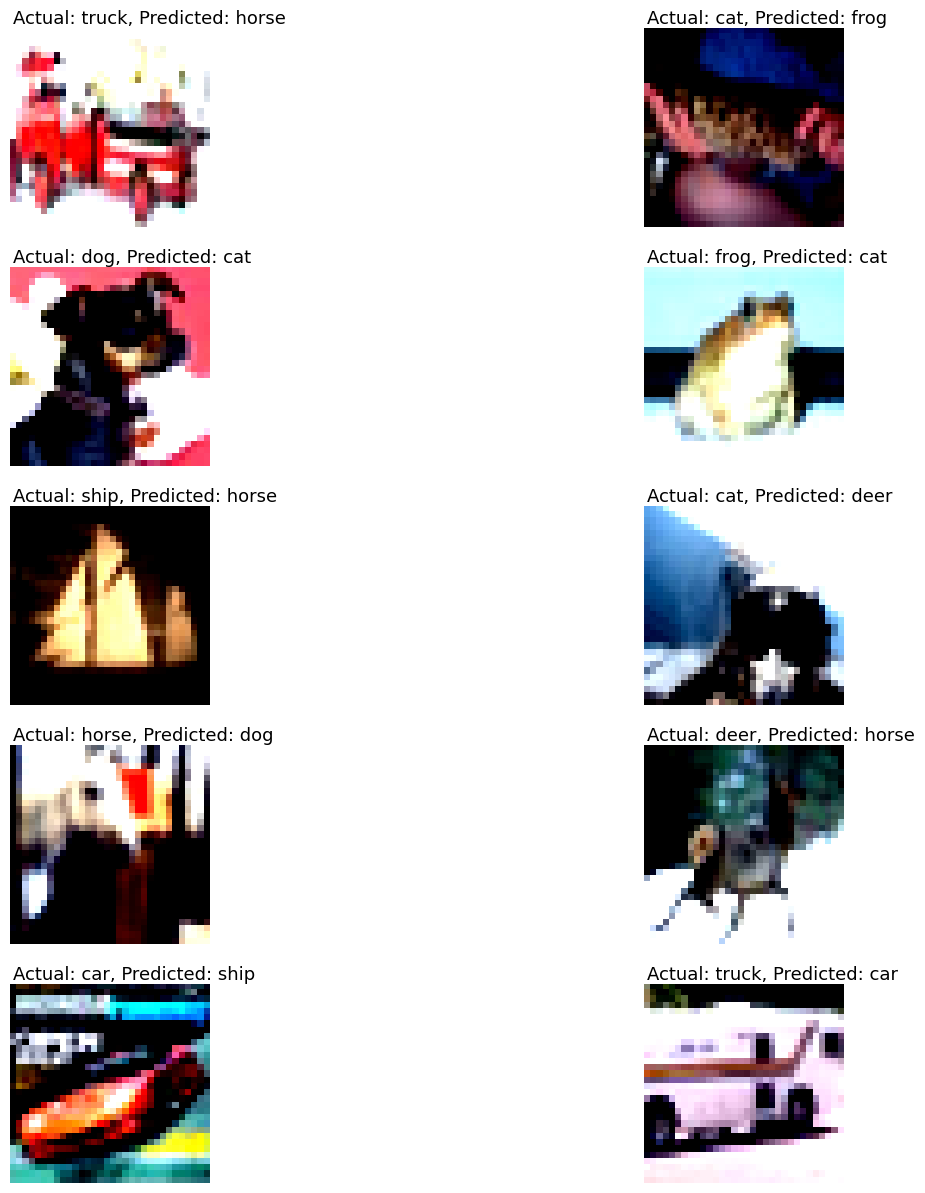

In [19]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
show_misclassified_images_from_model(cifar10_model, "./cifar_10_bn.pth", test_loader, classes, 10)